In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [59]:
df = pd.read_csv("./DSCI_522_group-314/data/cleaned-credit-default-data.csv", index_col=0)
# df = df.drop(columns=['ID'])
df = df.rename(columns={'default payment next month':'DEFAULT_NEXT_MONTH',
                        'PAY_0': 'PAY_1'})
df.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [60]:

X = df.drop(columns=['DEFAULT_NEXT_MONTH'])
y = df['DEFAULT_NEXT_MONTH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=122)

> We use robust scalar as most of our data is not normally distributed and we have a high amount of outliers.

In [61]:
columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

scaler = preprocessing.RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns )
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=columns)


> Use RFE to identify the most identify the most useful predictors. Then we will drop those columns that are deemed as less useful.

In [62]:
logreg = LogisticRegression(solver="lbfgs")
rfe = RFE(logreg, 14)
rfe = rfe.fit(X_train, y_train.values.ravel())
columns_to_drop = list()
for i in range(len(rfe.support_)):
    include = rfe.support_[i]
    if include == False:
        columns_to_drop.append(columns[i])
print(columns_to_drop)
X_train = X_train.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

['PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


> Confirm that that all our remaining predictors are significant using the p values in sm.logits' summary function

In [93]:
logit_model=sm.Logit(y_train.values.ravel(),X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.516573
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.023      
Dependent Variable: y                AIC:              23273.7720 
Date:               2020-01-20 20:01 BIC:              23386.0698 
No. Observations:   22500            Log-Likelihood:   -11623.    
Df Model:           13               LL-Null:          -11895.    
Df Residuals:       22486            LLR p-value:      9.0920e-108
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
LIMIT_BAL       0.0446    0.0296   1.5042  0.1325  -0.0135   0.1027
SEX             0.7774    0.0298  26.0815  0.0000

In [64]:
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_train.columns)

> Find the best C value for our model

In [65]:
hyperparameters = {
    'C': np.logspace(-4, 4, 20)
}
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(os_data_X, os_data_y)
c_value = best_model.best_estimator_.get_params()['C']
print(f"c value:{c_value}")

c value:0.0018329807108324356


In [90]:
train_predictions = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
accuracies_df = pd.DataFrame(index=['test accuracy', 'train accuracy', 'test recall', 'test precision'],data={
    'result': [test_accuracy, train_accuracy, test_recall, test_precision ]
})
#accuracies_df.to_csv('/results/accuracies')

,result
test accuracy,0.687200
train accuracy,0.684844
test recall,0.658610
test precision,0.379659


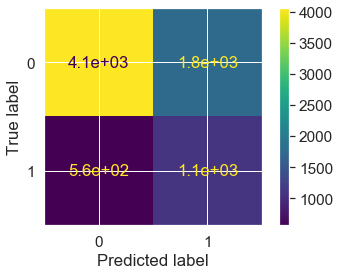

In [95]:
plot_confusion_matrix(best_model, X_test, y_test)
report = classification_report(y_test, test_predictions, output_dict=True)
report_df = pd.DataFrame(report)
#report_df.to_csv('/results/classification_report')

4. auc score and roc plot
0.7230038843331895


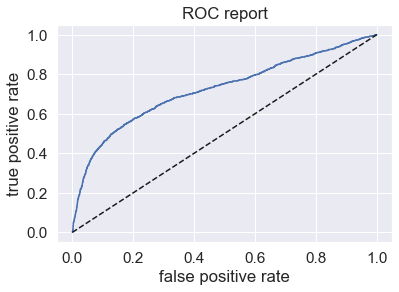

In [96]:

fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
print("4. auc score and roc plot")
print(auc_score)
plt.plot(fpr, tpr);
plt.title('ROC report')
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
#plt.savefig('./results/roc.png');